## General HashMap Implementation

In [71]:
class list_node:
    def __init__(self, key, value, next_node):
        self.key = key
        self.value = value
        self.next_node = next_node    

class hashmap:
    def __init__(self, hash_func, capacity):
        self.hash_func = hash_func
        self.capacity = capacity
        self.size = 0
        self.slots = [None] * capacity
        
    def put(self, key, value):
        hash = self.hash_func(key)
        node = self.slots[hash]
        if node is None:
            self.slots[hash] = list_node(key, value, None)
            self.size += 1
        else:
            while True:
                if (node.key == key):
                    node.value = value
                    return
                elif (node.next_node is None):
                    node.next_node = list_node(key, value, None)
                    self.size += 1
                    return
                else:
                    node = node.next_node
                    
    def get(self, key):
        hash = self.hash_func(key)
        node = self.slots[hash]
        while True:
            if node is None:
                return None
            elif node.key == key:
                return node.value
            else:
                node = node.next_node
        
    def to_string(self):
        entries = []
        for node in self.slots:
            while node is not None:
                entries.append(str(node.key) + " => " + str(node.value))
                node = node.next_node
        
        return "{" + ", ".join(entries) + "}"
    
    def get_empty_slots_count(self):
        empty_slots = 0
        for node in self.slots:
            if node is None:
                empty_slots += 1
        return empty_slots
    
    def get_collisions_count(self):
        collisions = 0
        for node in self.slots:
            if node is not None:
                while node.next_node is not None:
                    collisions += 1
                    node = node.next_node
        return collisions
    
    def get_meta_info(self):
        size = self.size
        capacity = self.capacity
        empty_slots = self.get_empty_slots_count()
        collisions = self.get_collisions_count()
        template = "hashmap[size=%d, capacity=%d, empty_slots=%d, collisions=%d]"
        return  template % (size, capacity, empty_slots, collisions)

## Hash Functions

In [147]:
# cdf hash functions
def compute_position_cdf(key, cdf, max_key, table_size):
    position = cdf(key / max_key) * table_size
    if position < 0:
        return 0
    elif position >= table_size:
        return table_size - 1
    else:
        return int(position)
    
def create_cdf_hash_func(cdf, max_key, table_size):
    return lambda key: compute_position_cdf(key, cdf, max_key, table_size)

# random hash functions (https://stackoverflow.com/a/12996028)
def compute_position_hash(key, table_size):
    x = key
    x = ((x >> 16) ^ x) * 0x45d9f3b;
    x = ((x >> 16) ^ x) * 0x45d9f3b;
    x = (x >> 16) ^ x;
    return x % table_size;

def create_random_hash_func(table_size):
    return lambda key: compute_position_hash(key, table_size)

## Common imports and utils

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv

%matplotlib inline

def sparse(arr, times):
    return [arr[i] for i in range(len(arr)) if i % times == 0]

## Credit Card Fraud Dataset (tx-dataset)
[download](https://www.kaggle.com/mlg-ulb/creditcardfraud)

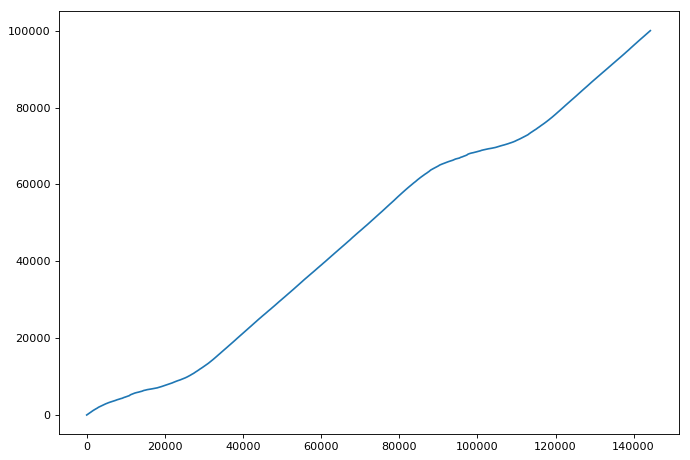

In [78]:
def load_tx_dataset_timestamps():
    # load data
    names = None
    rows = []
    last_row = None
    with open('../../datasets/creditcard.csv') as csvfile:
        csvdata = csv.reader(csvfile)
        first_line = True;
        for row in csvdata:
            if (first_line):
                names = row
                first_line = False
            elif last_row is None or last_row[0] != row[0]:
                rows.append(row)
                last_row = row
                
    # preprocess data
    timestamps_strings_with_duplicates = [int(float(ts)) for ts in [row[0] for row in rows][0:100000]]
    timestamps_with_duplicates = [int(ts) for ts in timestamps_strings_with_duplicates]
    timestamps = np.array(sorted(list(set(timestamps_with_duplicates))))
    
    return timestamps

tx_dataset_keys = load_tx_dataset_timestamps()
tx_dataset_size = len(tx_dataset_keys)
tx_dataset_min_key = min(tx_dataset_keys)
tx_dataset_max_key = max(tx_dataset_keys)
tx_dataset_positions = [i for i in range(tx_dataset_size)]

plt.figure(figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(tx_dataset_keys, tx_dataset_positions)

## US Population By Zip Code Dataset (zc-dataset)
[download](https://www.kaggle.com/census/us-population-by-zip-code)

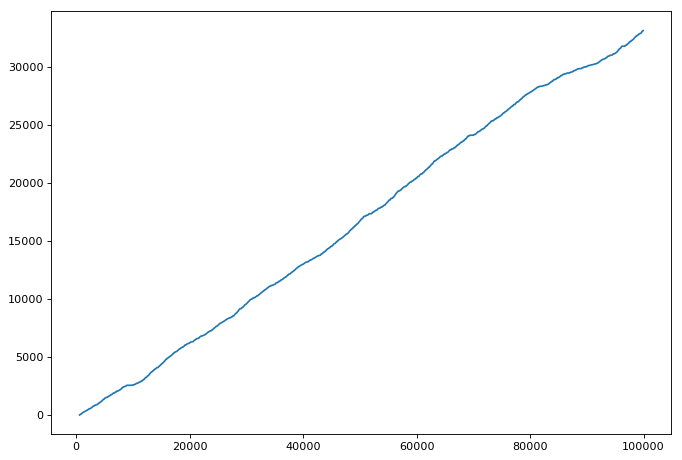

In [153]:
def load_zc_dataset_zipcodes():
    names = None
    rows = []
    with open('../../datasets/us_zipcode_to_population.csv') as csvfile:
        csvdata = csv.reader(csvfile)
        first_line = True;
        for row in csvdata:
            if (first_line):
                names = row
                first_line = False
            else:
                rows.append(row)
                
    return np.array([int(row[0]) for row in rows])

zc_dataset_keys = load_zc_dataset_zipcodes()
zc_dataset_size = len(zc_dataset_keys)
zc_dataset_min_key = min(zc_dataset_keys)
zc_dataset_max_key = max(zc_dataset_keys)
zc_dataset_positions = [i for i in range(zc_dataset_size)]

plt.figure(figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(zc_dataset_keys, zc_dataset_positions)

# k_min = 16000;
# shift = 100
# plt.plot(zc_dataset_keys[k_min:k_min+shift], zc_dataset_positions[k_min:k_min+shift], 'bo')

## Linear Regression Model

In [208]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

def train_linreg_cdf(xs, ys, degree):
    poly = PolynomialFeatures(degree=degree)
    transform_xs = lambda xs: poly.fit_transform(xs.reshape(-1, 1))

    reg = linear_model.LinearRegression()
    reg.fit(transform_xs(xs), ys)
    
    return lambda x: reg.predict(transform_xs(np.array([x])))

def find_best_linreg_cdf(keys):
    max_key = max(keys)
    keys_count = len(keys)
    positions = np.array([i for i in range(keys_count)])
    max_position = keys_count - 1
    
    # normalize
    xs = keys / max_key
    ys = positions / max_position
    
    max_degree = 20
    min_empty_slots = keys_count
    selected_degree = 0
    selected_hash_func = None
    for degree in range(1, max_degree + 1):
        cdf = train_linreg_cdf(xs, ys, degree)
        
        # check collisions
        table_size = keys_count
        hash_func = create_cdf_hash_func(cdf, max_key, table_size)
        hmap = hashmap(hash_func, table_size)
        for key in keys:
            hmap.put(key, "")
            
        print("---")
        print("degree = " + str(degree))
        print(hmap.get_meta_info())
            
        empty_slots = hmap.get_empty_slots_count()
        if (empty_slots < min_empty_slots):
            print("===selected current hash func as best===")
            min_empty_slots = empty_slots
            selected_degree = degree
            selected_hash_func = hash_func  
        
    return selected_hash_func

In [211]:
hash_func = find_best_linreg_cdf(zc_dataset_keys)

---
degree = 1
hashmap[size=33119, capacity=33119, empty_slots=17043, collisions=17043]
===selected current hash func as best===
---
degree = 2
hashmap[size=33119, capacity=33119, empty_slots=16988, collisions=16988]
===selected current hash func as best===
---
degree = 3
hashmap[size=33119, capacity=33119, empty_slots=16954, collisions=16954]
===selected current hash func as best===
---
degree = 4
hashmap[size=33119, capacity=33119, empty_slots=17005, collisions=17005]
---
degree = 5
hashmap[size=33119, capacity=33119, empty_slots=17009, collisions=17009]
---
degree = 6
hashmap[size=33119, capacity=33119, empty_slots=16777, collisions=16777]
===selected current hash func as best===
---
degree = 7
hashmap[size=33119, capacity=33119, empty_slots=16618, collisions=16618]
===selected current hash func as best===
---
degree = 8
hashmap[size=33119, capacity=33119, empty_slots=16658, collisions=16658]
---
degree = 9
hashmap[size=33119, capacity=33119, empty_slots=16645, collisions=16645]
---

In [184]:
keys = zc_dataset_keys
expected_positions = zc_dataset_positions
actual_positions = np.array([hash_func(key) for key in keys])

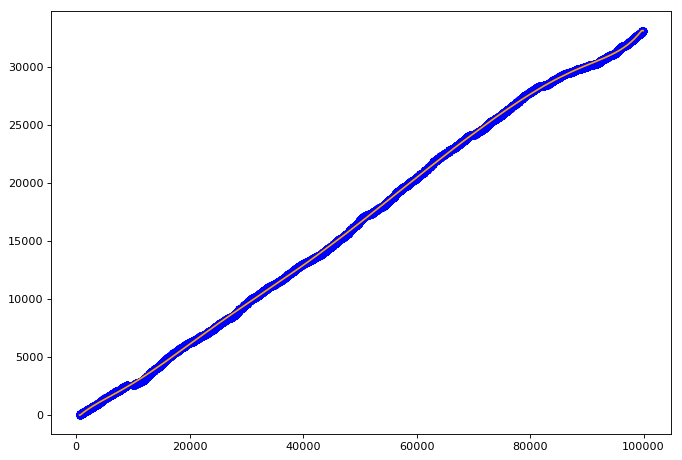

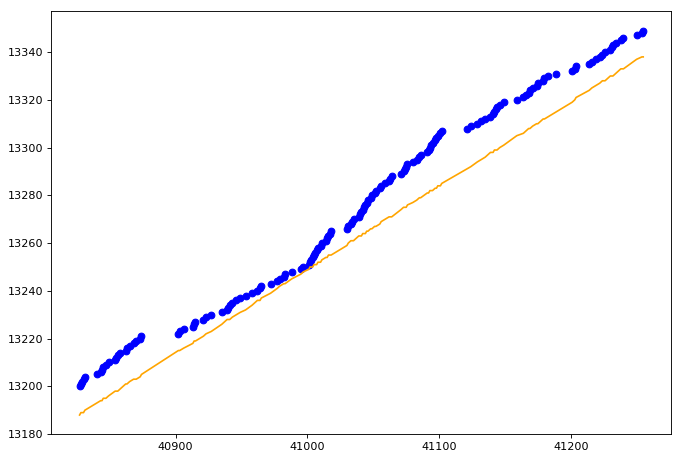

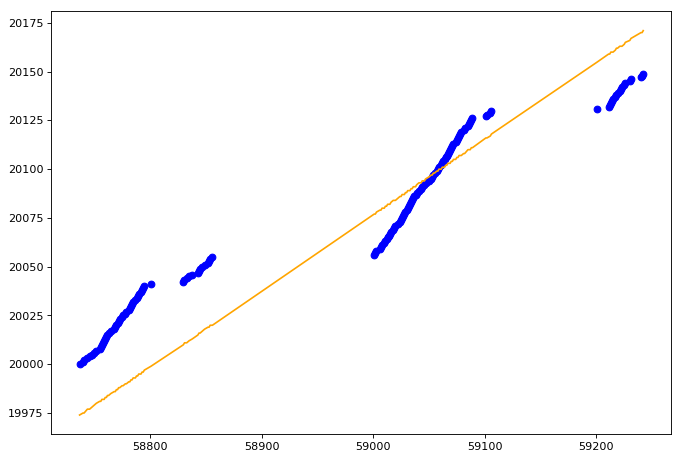

In [201]:
k_min = 0;
shift = zc_dataset_size

plt.figure(figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(keys[k_min:k_min+shift], expected_positions[k_min:k_min+shift], "bo")
plt.plot(keys[k_min:k_min+shift], actual_positions[k_min:k_min+shift], "orange")
plt.show()

# scale
k_min = 13200;
shift = 150

plt.figure(figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(keys[k_min:k_min+shift], expected_positions[k_min:k_min+shift], "bo")
plt.plot(keys[k_min:k_min+shift], actual_positions[k_min:k_min+shift], "orange")
plt.show()

# # scale
# k_min = 12000;
# shift = 100

# plt.figure(figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(keys[k_min:k_min+shift], expected_positions[k_min:k_min+shift], "bo")
# plt.plot(keys[k_min:k_min+shift], actual_positions[k_min:k_min+shift], "yellow")
# plt.show()

# # scale
# k_min = 15000;
# shift = 100

# plt.figure(figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(keys[k_min:k_min+shift], expected_positions[k_min:k_min+shift], "bo")
# plt.plot(keys[k_min:k_min+shift], actual_positions[k_min:k_min+shift], "yellow")
# plt.show()

# scale
k_min = 20000;
shift = 150

plt.figure(figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.plot(keys[k_min:k_min+shift], expected_positions[k_min:k_min+shift], "bo")
plt.plot(keys[k_min:k_min+shift], actual_positions[k_min:k_min+shift], "orange")
plt.show()

# # scale
# k_min = 25000;
# shift = 100

# plt.figure(figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
# plt.plot(keys[k_min:k_min+shift], expected_positions[k_min:k_min+shift], "bo")
# plt.plot(keys[k_min:k_min+shift], actual_positions[k_min:k_min+shift], "yellow")
# plt.show()